### Trying to reproduce the figures in [Martingale Posterior Distributions]

In [271]:
import scipy.stats as scs
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad,cumtrapz


# Figure 1:

Data density $f(y) = N(\theta,1)$ with prior $\Pi(\theta) = N(0,1)$

This results in the predictive $p(y|y_{1:n}) = N(y|\bar{\theta_n}, 1+\bar{\sigma^{2}_{n}})$ with
$\bar{\theta_n} = \frac{\sum_{i=1}^{n} y_i }{n+1}$ and $\bar{\sigma^{2}_{n}} = \frac{1}{n+1}$.

The posterior density $\Pi(\theta|y_{1:n})=N(\theta|\bar{\theta_n},\bar{\sigma^{2}_n})$

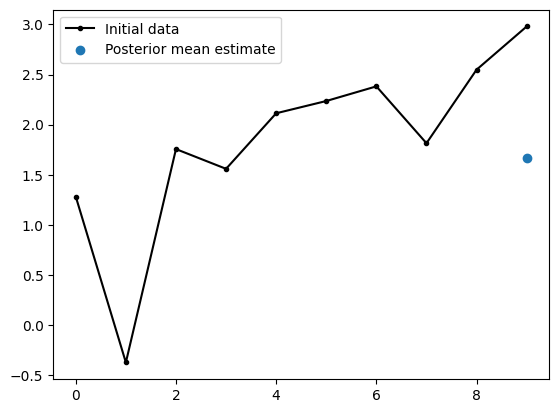

In [5]:
# Set true parameters: theta the mean, n the initial obs

theta = 2
n = 10

initial_obs_data = scs.norm.rvs(loc=2,scale=1,size=n)
plt.plot(initial_obs_data,label='Initial data',marker='.',color='black')
plt.scatter(x=9,y=np.sum(initial_obs_data)/11,label='Posterior mean estimate')
plt.legend()
plt.show()

In [6]:
# paths for posterior estimate
nb_paths = 100
nb_steps = 1000

list_of_mean_paths = []
list_of_paths = []
for path in tqdm(range(nb_paths)):
    current_path = list(initial_obs_data)
    mean_of_path = [np.sum(initial_obs_data)/11]
    for step in range(nb_steps):
        obs = scs.norm.rvs(loc=mean_of_path[step],scale=(1/(11+step))+1)
        current_path.append(obs)
        #update mean and var
        mean_of_path.append(np.sum(current_path)/(12+step))
    list_of_mean_paths.append(mean_of_path)
    list_of_paths.append(current_path)

100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


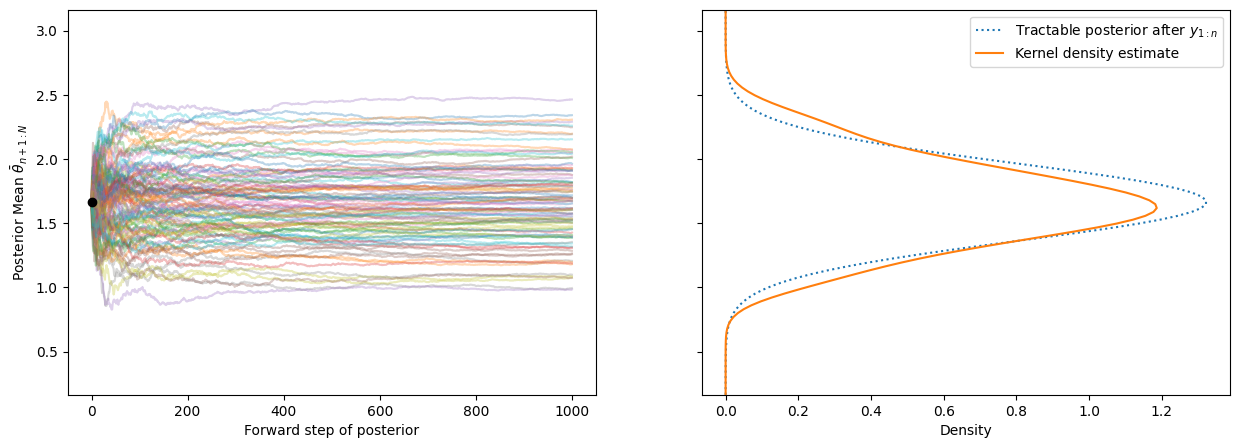

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True,figsize=(15,5))
for idx,ax in enumerate(ax.flat):
    ax.set(ylabel='Posterior Mean '+r'$\bar{\theta}_{n+1:N}$')
    ax.label_outer()
    if idx ==0:
        ax.plot(np.transpose(np.array(list_of_mean_paths)),alpha=0.3)
        ax.set_ylim([np.sum(initial_obs_data)/11-1.5,np.sum(initial_obs_data)/11+1.5])
        ax.scatter(0,np.sum(initial_obs_data)/11,color='black',zorder=10)
        ax.set(xlabel='Forward step of posterior')
    if idx==1:
        x = np.linspace(np.sum(initial_obs_data)/11-1.5,np.sum(initial_obs_data)/11+1.5,100)
        posterior = scs.norm(loc=np.sum(initial_obs_data)/11,scale=np.sqrt(1/11))
        ax.plot(posterior.pdf(x),x,label='Tractable posterior after '+r'$y_{1:n}$',linestyle='dotted')

        ax.plot(scs.gaussian_kde(np.array(list_of_mean_paths)[:,-1]).evaluate(x),x,label='Kernel density estimate')
        ax.legend()
        ax.set_ylim([np.sum(initial_obs_data)/11-1.5,np.sum(initial_obs_data)/11+1.5])
        ax.set(xlabel='Density')


# Hahn $et \, al.$ in the case of Normal conjugacy:

Covers the case of univariate Normal, which gives rise to an analytically tractable update. We have:

Data density $f(y|\theta)=N(y|\theta,1)$ with (conjugate) prior $N(\theta)=N(\theta|0,\tau^{-1})$, here we will choose $\tau = 1$.

The predictive updates are then parameterised by a Gaussian copula with correlation parameter $\rho_n=(n+\tau)^{-1}$. In particular, the prequential copula used to propagate the predictive density is:

$c_{\rho}(u,v)=\frac{N_2(\Phi^{-1}(u),\Phi^{-1}(v)|0,1,\rho)}{N(\Phi^{-1}(u)|0,1)\cdot N(\Phi^{-1}(v)|0,1)}$


Finally, the predictive density is given by:

$p_{n-1}(y)=N(y|\frac{T_{n-1}}{n-1+\tau},\frac{n+\tau}{n-1+\tau})$ with  $T_{n-1}=y_1+\cdots+    y_{n-1}$


STATUS: recursion is working, but I encountered a bottleneck due to integration. Since we are working on densities, the distribution terms inside copulas whoch relate to the new observation ($u=F_(i-1)(x)$) are not known and have to instead be computed as integrals of $f_(i-1)$ from -inf to x. Because of the recursion, we have to compute an increasing number of these integrals, causing a 10x increase in time at each step. -this is where I started working on the DPMM example instead.

In [264]:
# density function
def p(x,theta,v):
    return scs.norm(loc=theta).pdf(x)

# function for copula based update
def update_p(p_,rho):
    def updated_p(x,theta,v):
        inv_u = scs.norm.ppf(np.clip(quad(p_,-np.inf,x,args=(0,v),limit=1,epsabs=1e-2,epsrel=1e-2)[0],1e-20,1-(1e-10)))
        inv_v = scs.norm.ppf(v)
        out = scs.multivariate_normal.logpdf((inv_u,inv_v),mean=np.zeros(2),cov=np.array([1,rho,rho,1]).reshape(2,2)) 
        out -= scs.norm.logpdf(inv_v)
        out -= scs.norm.logpdf(inv_u)
        out += np.log(np.clip(p_(x,theta,v),1e-6,1-(1e-6)))
        return np.exp(out)
    return updated_p

In [265]:
# update step 0
predictives = []
predictives.append(p)
predictives.append(update_p(predictives[0],0))
predictives.append(update_p(predictives[1],0))
predictives.append(update_p(predictives[2],0))

# as proposal in IS, use a T dist




In [266]:
predictives = []
predictives.append(p)
for i in range(5):
    predictives.append(update_p(predictives[i],0))

In [ ]:
predictives[2](0,0,np.random.uniform())

# DPMM example, section 4.2 in the RSS paper

Here, they have a form for the recursions of densities $f_i(x)$ and $F_i(x)$, solving the problem of integration in the normal case.

# Notes on how this works.

In the 2022 paper, $y_{i+1}$ is the current observation, to which we have access and $y$ is the future observation we are simulating.